In [2]:
%pip install gdown catboost optuna >> None 

  Using cached gdown-5.1.0-py3-none-any.whl (17 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
Note: you may need to restart the kernel to use updated packages.


### Основная идея

Все кластера состоят из продуктов, которыми пользуется юридическое лицо: попробуем предсказать не кластер, а набор продуктов. Таким образом нам потребуется получить 22 модели - по 2 (отток и склонность) на каждый продукт банка. 

In [1]:
import pickle
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import tqdm

import functools
import operator
import random
import string

import numpy as np
import pandas as pd
from scipy import stats

SEED = 42

In [2]:
train_df = pd.read_parquet("train_data.pqt")
test_df = pd.read_parquet("test_data.pqt")

In [3]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [4]:
test_df[test_df["date"] == "month_5"].shape, test_df[test_df["date"] == "month_6"].shape

((100000, 92), (100000, 92))

In [42]:
cat_feats = [
    "channel_code", "city", "city_type",
    "okved", "segment", 'start_cluster',
    "index_city_code", "ogrn_month", "ogrn_year",
]

In [7]:
products_list = ['α', 'ε', 'θ', 'π', 'β', 'λ', 'ψ', 'μ', 'δ', 'γ', 'η', 'other']

In [9]:
def get_cluster_dict(df: pd.DataFrame) -> dict():
    
    products_in_dict = {}
    for i, row in df.iterrows():
        if row['start_cluster'] == '{other}' or row['start_cluster'] == '{}': pass 
        else:
            prod_in =  (row['start_cluster'].strip('{}').split(', '))
            products_in_dict[row['start_cluster']] = (prod_in)
        
    return products_in_dict

clusters_dict = get_cluster_dict(train_df)
clusters_dict

{'{α, γ}': ['α', 'γ'],
 '{α}': ['α'],
 '{α, ε, ψ}': ['α', 'ε', 'ψ'],
 '{α, δ}': ['α', 'δ'],
 '{α, η}': ['α', 'η'],
 '{α, β}': ['α', 'β'],
 '{α, ε, η}': ['α', 'ε', 'η'],
 '{α, μ}': ['α', 'μ'],
 '{α, ψ}': ['α', 'ψ'],
 '{α, λ}': ['α', 'λ'],
 '{α, ε}': ['α', 'ε'],
 '{α, ε, θ}': ['α', 'ε', 'θ'],
 '{α, θ}': ['α', 'θ'],
 '{λ}': ['λ'],
 '{α, π}': ['α', 'π']}

### Бинарные флаги наличия продукта у клиента
1) в трейне
2) в тесте по пятому месяцу

In [11]:
def bin_marks_df(df: pd.DataFrame, cluster_type='start_cluster'):
    """ получаем датафрейм где ключ - продукт значения список 
    длины датафрейма с метками 0/1, где  каддое значение 1 - 
    наличие у клиента 
    """
    products_in_dict = {}
    for prod in products_list:
        if prod not in products_in_dict:
            # создаём словарь продуктов и заполняем нулями 
            products_in_dict[prod] = [0] * df.shape[0] 
        
            
    for i, row in df.iterrows():
        # получаем список продуктов у клиента 
        
        prod_in = (row[cluster_type].strip('{}').split(', '))
        
        #print(prod_in)
        for prod in prod_in:
            '''if prod == 'other':
                continue '''
            if prod != '': #and prod != 'other': # что бы вернуть other - поменять products_list 
                #print(i)
                products_in_dict[prod][i] = 1
            else:
                pass
        
    df_bin_mark = pd.DataFrame(
        {"id": df['id'].tolist(), # в этом случае каждого id по три раза как и в train
        **(products_in_dict)}
    )
    
    return df_bin_mark

In [12]:
bin_flags = bin_marks_df(train_df)
bin_flags.head(5)

,id,α,ε,θ,π,β,λ,ψ,μ,δ,γ,η,other
0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
bin_flags_for_end_clust = bin_marks_df(df = train_df, cluster_type='end_cluster')

bin_flags_for_end_clust

,id,α,ε,θ,π,β,λ,ψ,μ,δ,γ,η,other
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,0,0,0,0,0,0,0,0,0,0,0,0
599996,199998,0,0,0,0,0,0,0,0,0,0,0,0
599997,199999,0,0,0,0,0,0,0,0,0,0,0,0
599998,199999,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
prod_matrix_end_clstr = bin_flags_for_end_clust.drop(['id'], axis=1)
sum_per_column = prod_matrix_end_clstr.sum()
total_sum = prod_matrix_end_clstr.sum().sum()

prod_freq = dict(
    zip(products_list[:-1], [
        sum_per_column[0]/total_sum, 
        sum_per_column[1]/total_sum,
        sum_per_column[2]/total_sum,
        sum_per_column[3]/total_sum, 
        sum_per_column[4]/total_sum, 
        sum_per_column[5]/total_sum, 
        sum_per_column[6]/total_sum, 
        sum_per_column[7]/total_sum, 
        sum_per_column[8]/total_sum, 
        sum_per_column[9]/total_sum, 
        sum_per_column[10]/total_sum,])
)
current_sum = sum(prod_freq.values())

target_sum = 1
adjustment_factor = target_sum / current_sum

# Пропорционально увеличиваем значения
adjusted_values = {k: v * adjustment_factor for k, v in prod_freq.items()}
new_sum = sum(adjusted_values.values())

adjusted_values, new_sum

C:\Users\tliso\AppData\Local\Temp\ipykernel_19760\4263706417.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_per_column[0]/total_sum,
C:\Users\tliso\AppData\Local\Temp\ipykernel_19760\4263706417.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_per_column[1]/total_sum,
C:\Users\tliso\AppData\Local\Temp\ipykernel_19760\4263706417.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_per_column[2]/total_sum,
C:\Users\t

({'α': 0.7892114066878932,
  'ε': 0.01579167461447038,
  'θ': 0.014005252886886855,
  'π': 3.48480624477279e-05,
  'β': 0.0205475180843103,
  'λ': 0.0018579519610288611,
  'ψ': 0.006034217129106568,
  'μ': 0.0038938124513961223,
  'δ': 0.007479494666412336,
  'γ': 0.06322355582292781,
  'η': 0.07792026763311959},
 0.9999999999999997)

In [34]:
def bin_marks_test(df: pd.DataFrame):
    """ получаем датафрейм где ключ - продукт значения список 
    длины датафрейма с метками 0/1, где  каддое значение 1 - 
    наличие у клиента 
    """
    products_in_dict = {}
    for prod in products_list:
        if prod not in products_in_dict:
            # создаём словарь продуктов и заполняем нулями 
            products_in_dict[prod] = [0] * test_df.shape[0] 
        
            
    for i, row in df.iterrows():
        # получаем список продуктов у клиента 
        
        prod_in = (row['start_cluster'].strip('{}').split(', '))
        
        for prod in prod_in:
            if prod != '': 
                products_in_dict[prod][i] = 1
            else:
                pass
        
    df_bin_mark = pd.DataFrame(
        {"id": test_df['id'].tolist(), # в этом случае каждого id по три раза как и в train
        **(products_in_dict)}
    )
    
    return df_bin_mark

In [35]:
month_5_df = test_df[test_df["date"] == "month_5"].copy()

bin_flags_for_test = bin_marks_test(month_5_df)
bin_flags_for_test = bin_flags_for_test.loc[month_5_df.index]
bin_flags_for_test

,id,α,ε,θ,π,β,λ,ψ,μ,δ,γ,η,other
1,200000,1,0,0,0,0,0,0,0,0,0,0,0
4,200001,1,0,0,0,0,0,0,0,0,0,0,0
7,200002,0,0,0,0,0,0,0,0,0,0,0,1
10,200003,1,0,0,0,0,0,0,0,0,0,0,0
12,200004,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290107,299995,1,0,0,0,0,0,0,0,0,0,0,0
290110,299996,1,0,0,0,0,0,0,0,0,0,0,0
290113,299997,1,0,0,0,0,0,0,0,0,0,0,0
290115,299998,0,0,0,0,0,0,0,0,0,0,0,0


### Обучение моделей притока и оттока с каждого продукта 

In [36]:
def df_by_proguct_to_propensity(product : str, indexes = None, data = train_df):
    
    if indexes is not None:
        prop_df = train_df.iloc[indexes]
    else:
        prop_df = train_df.copy() 
    target = []
    # Создаём таргет, проверяя наличие продукта в конечном кластере 
    for i, row in train_df.iterrows():
        if i in range(0, train_df.shape[0]):
            end_products = (row['end_cluster'].strip('{}').split(', '))
            start_products = (row['start_cluster'].strip('{}').split(', '))
            #print(end_products)
            if product in end_products and product not in start_products:
                target.append(1)
            else:
                target.append(0)
        

    prop_df = prop_df.drop(['id', 'date',], axis=1) 
    prop_df['target'] = target
    
    return prop_df

def df_by_proguct_to_churn(product : str, indexes = None):
    
    if indexes is not None:
        churn_df = train_df[indexes]
    else:
        churn_df = train_df.copy()  
    target = []
    # Создаём таргет, проверяя наличие продукта в конечном кластере 
    for i, row in train_df.iterrows():
        if i in range(0, train_df.shape[0]):
            end_products = (row['end_cluster'].strip('{}').split(', '))
            start_products = (row['start_cluster'].strip('{}').split(', '))
            #print(end_products)
            if product in start_products and product not in end_products:
                target.append(1)
            else:
                target.append(0)
        

    churn_df = churn_df.drop(['id', 'date',], axis=1) 
    churn_df['target'] = target
    
    return churn_df


In [37]:
def proprnsity_models(products_list = products_list):

    models_by_prod = dict()

    for product in products_list[:-1]:
        df_by_prod = df_by_proguct_to_propensity(product)
        df_by_prod.fillna(0, inplace=True)
        
        model = CatBoostClassifier(
            random_seed=SEED,
            cat_features=cat_feats,
            task_type = 'GPU',
            devices = '0:1'
        )

        model.fit(
                df_by_prod.drop(['end_cluster', 'target'], axis=1), 
                df_by_prod.target,
                verbose=200
            ) 
        
        model_filename = f"model_wsc_{product}_propensity.pkl"
        with open(model_filename, 'wb') as file:
            pickle.dump(model, file)
        models_by_prod[f"{product}_propensity"] = model

    return models_by_prod

def churn_models(products_list = products_list):

    models_by_prod = dict()

    for product in products_list[:-1]:
        df_by_prod = df_by_proguct_to_churn(product)
        df_by_prod.fillna(0, inplace=True)
        
        model = CatBoostClassifier(
            random_seed=SEED,
            cat_features=cat_feats,
            task_type = 'GPU',
            devices = '0:1'
        )

        model.fit(
                df_by_prod.drop(['end_cluster', 'target'], axis=1), 
                df_by_prod.target,
                verbose=200
            ) 
        
        model_filename = f"model_wsc_{product}_churn.pkl"
        with open(model_filename, 'wb') as file:
            pickle.dump(model, file)
        models_by_prod[f"{product}_churn"] = model

    return models_by_prod

In [43]:
proprnsity_models_dict = proprnsity_models(products_list=products_list)
# уже обучено НО С start_cluster

Learning rate set to 0.023712
0:	learn: 0.6023976	total: 168ms	remaining: 2m 48s
200:	learn: 0.0937751	total: 21.4s	remaining: 1m 25s
400:	learn: 0.0891946	total: 42.9s	remaining: 1m 4s
600:	learn: 0.0873129	total: 1m 4s	remaining: 42.6s
800:	learn: 0.0860455	total: 1m 25s	remaining: 21.2s
999:	learn: 0.0851376	total: 1m 46s	remaining: 0us
Learning rate set to 0.023712
0:	learn: 0.6357297	total: 208ms	remaining: 3m 27s
200:	learn: 0.0324026	total: 22s	remaining: 1m 27s
400:	learn: 0.0294906	total: 43.6s	remaining: 1m 5s
600:	learn: 0.0286490	total: 1m 5s	remaining: 43.5s
800:	learn: 0.0282213	total: 1m 27s	remaining: 21.8s
999:	learn: 0.0277748	total: 1m 49s	remaining: 0us
Learning rate set to 0.023712
0:	learn: 0.6346679	total: 371ms	remaining: 6m 10s
200:	learn: 0.0278516	total: 21.7s	remaining: 1m 26s
400:	learn: 0.0253269	total: 43.6s	remaining: 1m 5s
600:	learn: 0.0244157	total: 1m 5s	remaining: 43.3s
800:	learn: 0.0237522	total: 1m 27s	remaining: 21.6s
999:	learn: 0.0233509	total

In [44]:
proprnsity_models_dict

{'α_propensity': <catboost.core.CatBoostClassifier at 0x1c007bbab60>,
 'ε_propensity': <catboost.core.CatBoostClassifier at 0x1c15891ccd0>,
 'θ_propensity': <catboost.core.CatBoostClassifier at 0x1bf2b41da20>,
 'π_propensity': <catboost.core.CatBoostClassifier at 0x1bf2b3ab100>,
 'β_propensity': <catboost.core.CatBoostClassifier at 0x1bf8b2ff400>,
 'λ_propensity': <catboost.core.CatBoostClassifier at 0x1bf5a63fd00>,
 'ψ_propensity': <catboost.core.CatBoostClassifier at 0x1bf2b3a93c0>,
 'μ_propensity': <catboost.core.CatBoostClassifier at 0x1bf2b3ab880>,
 'δ_propensity': <catboost.core.CatBoostClassifier at 0x1bf2b41e320>,
 'γ_propensity': <catboost.core.CatBoostClassifier at 0x1bf5a558a90>}

In [29]:
import pickle
import os

# Укажите директорию, где хранятся модели
models_directory = 'C:\Files\DataScience\Practice\CLTV_Alfa'

# Получаем список всех файлов моделей в указанной директории
model_files = [file for file in os.listdir(models_directory) if file.endswith('.pkl')]

# Загружаем каждую модель и сохраняем в словарь
models = {}
for model_file in model_files:
    with open(os.path.join(models_directory, model_file), 'rb') as file:
        model_name = model_file.split('.')[0]  # Используем имя файла без расширения как ключ
        models[model_name] = pickle.load(file)

In [110]:
test_copy = test_df[test_df["date"] == "month_5"].drop(["id", "date"], axis=1)
test_copy

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
1,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,0,-1.533705,-1.683741,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,0,0.092087,1.220030,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α}
7,0.572242,1.502779,-0.125995,0.574963,channel_code_12,city_14,city_type_0,index_city_code_78,-1.069193,-1.528873,...,0.499912,0.949989,0.522704,2.442243,0.563940,0.841020,3.313686,0.256701,0.550364,{other}
10,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,0,-0.256297,-1.257854,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α}
12,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290107,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,1.601751,-0.638383,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α}
290110,-0.156064,-0.203645,-0.125995,-0.155598,channel_code_1,city_96,city_type_0,index_city_code_66,-0.604681,0.987728,...,-0.028584,0.944497,0.384773,-0.164153,0.548035,0.441020,-0.199132,0.252368,0.429485,{α}
290113,-0.121206,-0.148644,-0.121388,-0.120632,channel_code_17,city_85,city_type_0,index_city_code_103,0.440471,1.336181,...,-0.028584,0.944497,0.384773,0.083778,0.552047,0.685465,0.070113,0.258723,0.616298,{α}
290115,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{}


In [112]:
df = bin_flags_for_test.copy()
test_copy = test_df[test_df["date"] == "month_5"].drop(["id", "date", 'start_cluster'], axis=1)

for p in products_list[:-1]:
    df[f"{p}_propensity"] = (1 - df[p]) * [x[1] for x  in (models[f'model_{p}_propensity'].predict_proba(test_copy.loc[df.index]))]
    df[f"{p}_churn"] = df[p] * [x[1] for x  in (models[f'model_{p}_churn'].predict_proba(test_copy.loc[df.index]))]

df

,id,α,ε,θ,π,β,λ,ψ,μ,δ,...,ψ_propensity,ψ_churn,μ_propensity,μ_churn,δ_propensity,δ_churn,γ_propensity,γ_churn,η_propensity,η_churn
1,200000,1,0,0,0,0,0,0,0,0,...,0.003080,0.0,0.003052,0.0,0.007009,0.0,0.037304,0.0,0.004847,0.0
4,200001,1,0,0,0,0,0,0,0,0,...,0.000243,0.0,0.000356,0.0,0.000641,0.0,0.002231,0.0,0.003489,0.0
7,200002,0,0,0,0,0,0,0,0,0,...,0.009424,0.0,0.000458,0.0,0.006426,0.0,0.028273,0.0,0.002364,0.0
10,200003,1,0,0,0,0,0,0,0,0,...,0.000392,0.0,0.000472,0.0,0.000600,0.0,0.002001,0.0,0.020954,0.0
12,200004,0,0,0,0,0,0,0,0,0,...,0.003343,0.0,0.003159,0.0,0.002601,0.0,0.037519,0.0,0.096819,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290107,299995,1,0,0,0,0,0,0,0,0,...,0.001178,0.0,0.000301,0.0,0.001327,0.0,0.005171,0.0,0.000869,0.0
290110,299996,1,0,0,0,0,0,0,0,0,...,0.001645,0.0,0.001102,0.0,0.004302,0.0,0.018412,0.0,0.002151,0.0
290113,299997,1,0,0,0,0,0,0,0,0,...,0.002517,0.0,0.000763,0.0,0.006161,0.0,0.033838,0.0,0.002325,0.0
290115,299998,0,0,0,0,0,0,0,0,0,...,0.003343,0.0,0.003159,0.0,0.002601,0.0,0.037519,0.0,0.096819,0.0


**Вспомогательные функции для приведения скоров к логнормальному распределению с заданным средним**

In [117]:
def normalize_scores_mean(
    df: pd.DataFrame,
    score_col: str,
    target_mean: float = 0.2,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Генерация логнормального распределения от 0 до 1 с заданным средним
    """
    df = df.sort_values(score_col)
    shape = df.shape[0]

    rs = np.random.RandomState(random_state)
    if target_mean < 0.5:
        score = get_lognorm_with_mean(
            target_mean=target_mean, size=shape * 2, random_state=random_state
        )
    else:
        score = 1 - get_lognorm_with_mean(
            target_mean=1 - target_mean, size=shape * 2, random_state=random_state
        )
    df[score_col] = np.array(sorted(rs.choice(score, size=shape)))

    return df


def get_lognorm_with_mean(
    target_mean: float,
    size: int,
    random_state: int = 42,
    prc_eps: float = 10**-3,
    n_iter: int = 100,
    n_shape: int = 100_000,
):
    """
    Подбор логнормального распределения от 0 до 1 с заданным средним
    """
    u = 0.0
    s = 1.0
    scale = 1.0

    # допустимая ошибка генерации - 0.1% от target_mean
    eps = target_mean * prc_eps

    score = stats.lognorm.rvs(
        s=s, loc=u, scale=scale, size=n_shape, random_state=random_state
    )

    # цикл подбора scale
    low = 0.0001
    high = 20.0
    mid = None
    for i in range(n_iter):
        mid = (high + low) / 2
        score_ = score * mid
        mean = score_[score_ < 1].mean()
        if abs(mean - target_mean) < eps:
            break
        if mean < target_mean:
            low = mid
        else:
            high = mid

    score = stats.lognorm.rvs(
        s=s, loc=u, scale=mid, size=size * 2, random_state=random_state
    )
    return score[score < 1]

In [120]:
for p in products_list[:-1]:
    # разделим скоры на нулевые и нет, т.к. алгоритм присвоит ненулевой скор для всех входящих записей
    df_0 = df[df[f"{p}_propensity"] == 0].reset_index(drop=True)
    df_1 = df[df[f"{p}_propensity"] != 0].reset_index(drop=True)
    df_1 = normalize_scores_mean(df_1, f"{p}_propensity", target_mean=prod_freq[p])
    df = pd.concat([df_0, df_1], ignore_index=True)

    df_0 = df[df[f"{p}_churn"] == 0].reset_index(drop=True)
    df_1 = df[df[f"{p}_churn"] != 0].reset_index(drop=True)
    df_1 = normalize_scores_mean(df_1, f"{p}_churn", target_mean=1 - prod_freq[p])
    df = pd.concat([df_0, df_1], ignore_index=True)

In [154]:
df

,id,α,ε,θ,π,β,λ,ψ,μ,δ,...,ψ_propensity,ψ_churn,μ_propensity,μ_churn,δ_propensity,δ_churn,γ_propensity,γ_churn,η_propensity,η_churn
0,237438,0,0,0,0,0,0,0,0,0,...,0.008627,0.0,0.000266,0.0,0.014108,0.0,0.027829,0.00000,0.000369,0.000000
1,233336,1,0,0,0,0,0,0,0,0,...,0.031390,0.0,0.002676,0.0,0.028170,0.0,0.181757,0.00000,0.000558,0.000000
2,238313,1,0,0,0,0,0,0,0,0,...,0.062956,0.0,0.002353,0.0,0.078532,0.0,0.000000,0.97989,0.000560,0.000000
3,227588,0,0,0,0,0,0,0,0,0,...,0.014807,0.0,0.004062,0.0,0.060349,0.0,0.034982,0.00000,0.000560,0.000000
4,290447,1,0,0,0,0,0,0,0,0,...,0.011998,0.0,0.003258,0.0,0.007854,0.0,0.023462,0.00000,0.000603,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,240444,1,0,0,0,0,0,0,0,0,...,0.004704,0.0,0.014204,0.0,0.001370,0.0,0.001395,0.00000,0.000000,0.998774
99996,254018,1,0,0,0,0,0,0,0,0,...,0.005151,0.0,0.010349,0.0,0.002723,0.0,0.002370,0.00000,0.000000,0.998784
99997,202820,1,0,0,0,0,0,0,0,0,...,0.004927,0.0,0.011943,0.0,0.001442,0.0,0.001212,0.00000,0.000000,0.999036
99998,200052,1,0,0,0,0,0,0,0,0,...,0.004667,0.0,0.027232,0.0,0.015584,0.0,0.008486,0.00000,0.000000,0.999075


In [155]:
df[df[f"{p}_propensity"] != 0][f"{p}_propensity"].mean()

0.04987965496936932

In [156]:
df[df[f"{p}_churn"] != 0][f"{p}_churn"].mean()

0.950919980069149

### Алгоритм получения кластеров

In [157]:
def get_cluster_advanced(df, clst_name="cluster"):
    """
    Функция определения кластер клиента по набору продуктовых флагов
    """
    df = df.copy()
    # инифиализируем колонку кластера
    df[clst_name] = None

    # пройдемся по всем кластерам и продуктам, которые их образуют
    for name, flags in clusters_dict.items():
        # сформируем условие по каждому кластеру
        local_cond = []
        # итерируемся по всем продуктам
        for prod in products_list:
            # случай наличия продукта клиента в составе кластера
            if prod in flags:
                local_cond.append(df[prod] > 0)
            # случай отсутствия продукта клиента в составе кластера
            else:
                local_cond.append(df[prod] <= 0)
        # если по всем проверяемым условиям мы получили True
        # то присваиваем клиенту кластер
        local_cond = functools.reduce(operator.and_, local_cond)
        local_cond = local_cond & df[clst_name].isna()
        df.loc[local_cond, clst_name] = name

    # кластер предоттока: если нет никаких других флагов
    df.loc[df[products_list].sum(axis=1) == 0, clst_name] = "churn"

    # то,что не покрыли кластерами, запишем в other
    df.loc[df[clst_name].isna(), clst_name] = "other"

    return df

In [158]:
df2 = get_cluster_advanced(df)

In [159]:
df2["cluster"].value_counts(normalize=True, dropna=False)

cluster
{α}          0.58584
churn        0.17497
{α, η}       0.07097
other        0.05532
{α, γ}       0.05272
{α, β}       0.01847
{α, δ}       0.01405
{α, ε}       0.00800
{α, θ}       0.00697
{α, ψ}       0.00441
{α, μ}       0.00297
{α, ε, η}    0.00209
{α, λ}       0.00137
{α, ε, θ}    0.00117
{α, ε, ψ}    0.00046
{λ}          0.00021
{α, π}       0.00001
Name: proportion, dtype: float64

Добавим отток к кластерам

In [160]:
clusters_dict["{}"] = []

### Считаем вероятности


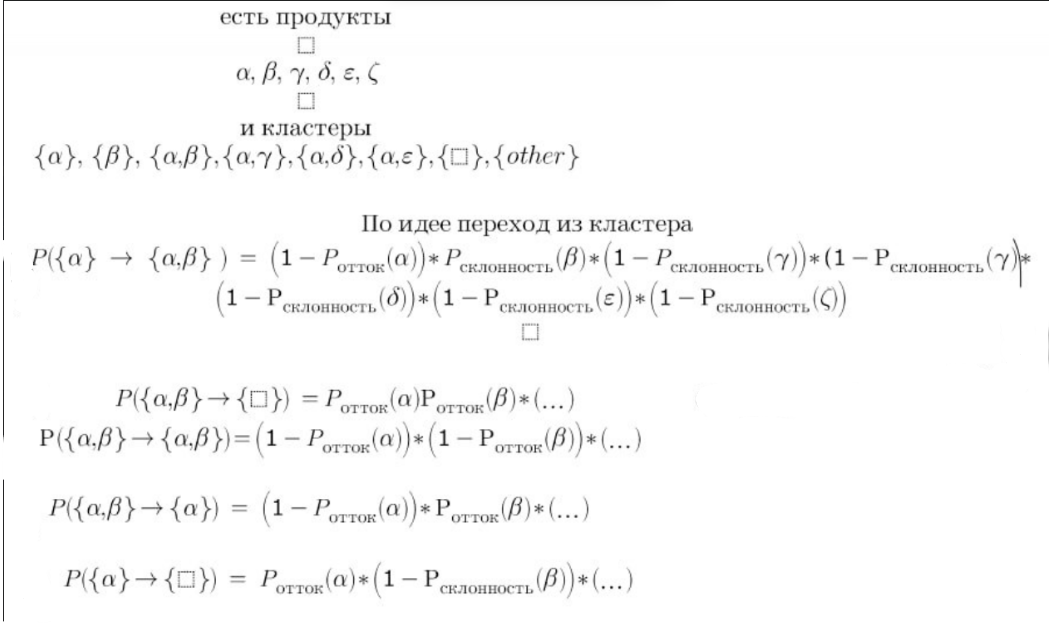

In [ ]:
def calc_full_probability(x, cluster, prods, cur_prods, products):
    """
    Рассчитывается вероятность перехода из текущего кластера в новый кластер
    :param x: датафрейм со скорами по всем моделям на дату по клиенту
    :param cluster: название кластера перехода
    :param prods: список названий продуктов кластера перехода
    :param cur_prods: список названий продуктов кластера клиента
    :param products: список названий всех возможных продуктов
    """
    x[cluster] = 1
    # продукты в прогнозном кластере и в кластере клиента
    # вероятности неоттока с продуктов
    for product in set(prods) & set(cur_prods):
        x[cluster] *= 1 - x[product + "_churn"]

    # продукты в прогнозном кластере, которых нет в кластере клиента
    # вероятности взятия продуктов
    for product in set(prods) - set(cur_prods):
        x[cluster] *= x[product + "_propensity"]

    # продукты, которых нет в прогнозном кластере и нет в кластере клиента
    # вероятности невзятия продуктов
    for product in set(products) - set(prods) - set(cur_prods):
        x[cluster] *= 1 - x[product + "_propensity"]

    # продукты в кластере клиента, которых нет в прогнозном кластере
    # вероятности оттока с продуктов
    for product in set(cur_prods) - set(prods):
        x[cluster] *= x[product + "_churn"]


def calc_full_probability_other(x, cluster, prods, products):
    """
    Вероятность перехода из кластера "Прочее" в новый кластер
    :param x: датафрейм со скорами по всем моделям на дату по клиенту
    :param cluster: id кластера перехода
    :param prods: список названий продуктов кластера перехода
    :param products: список названий всех возможных продуктов
    """
    # необходимо сначала получить список продуктов клиента
    cur_prods = np.array(products)[x[products].values == 1]
    calc_full_probability(x, cluster, prods, cur_prods, products)
    return x[cluster]

In [177]:
def calc_cluster_probability_advanced(df):
    """
    Ускоренная оценка вероятности перехода в каждый продуктовый кластер
    """
    res_df = df[["id", "cluster"]].reset_index(drop=True)
    # итерируемся по всем кластерам, для которых нужно спрогнозировать переход
    for cluster, clust_prods in clusters_dict.items():
        # инициализируем вероятность перехода
        res_df[cluster] = 1
        # итерируемся по всем продуктам
        for product in products_list[:-1]:
            # если продукт есть в прогнозном кластере клиента
            if product in clust_prods:
                # если продукт есть в текущем кластере клиента - вероятность неоттока
                # если продукта нет в текущем кластере клиента - вероятность склонности
                mult = (
                    df[product] * (1 - df[product + "_churn"])
                    + (1 - df[product]) * df[product + "_propensity"]
                )
                # собираем множители по всем продуктам
                res_df[cluster] *= mult
            # если продукта нет в прогнозном кластере клиента
            else:
                # если продукта нет в текущем кластере клиента - вероятность не склонности
                # если продукт есть в текущем кластере клиента - вероятность оттока
                mult = (1 - df[product]) * (1 - df[product + "_propensity"]) + (
                    df[product]
                ) * df[product + "_churn"]
                res_df[cluster] *= mult

    clusters = list(clusters_dict.keys())
    res_df["{other}"] = 1 - res_df[clusters].sum(axis=1)
    return res_df

In [178]:
df_proba2 = calc_cluster_probability_advanced(df2)

In [179]:
clusters = list(clusters_dict.keys()) + ["{other}"]

**Сумма всех вероятностей по каждому клиенту равна 1.**

In [180]:
df_proba2[clusters].sum(axis=1).mean()

1.0

In [181]:
df_proba2 = df_proba2.drop(['cluster'], axis=1)
df_proba2.head()

,id,"{α, γ}",{α},"{α, ε, ψ}","{α, δ}","{α, η}","{α, β}","{α, ε, η}","{α, μ}","{α, ψ}","{α, λ}","{α, ε}","{α, ε, θ}","{α, θ}",{λ},"{α, π}",{},{other}
0,237438,0.018767,0.655600,0.000001,0.009382,0.000242,0.028515,5.385856e-08,0.000175,0.005705,0.004214,0.000146,0.000003,0.013636,0.001325,0.018070,0.206218,0.038002
1,233336,0.116288,0.523512,0.000358,0.015175,0.000292,0.015877,6.173740e-06,0.001405,0.016966,0.025801,0.011051,0.000861,0.040809,0.004950,0.017814,0.100429,0.108407
2,238313,0.010238,0.498876,0.000307,0.042517,0.000279,0.102750,2.559350e-06,0.001177,0.033517,0.018955,0.004571,0.000424,0.046287,0.003913,0.007674,0.102988,0.125525
3,227588,0.022446,0.619186,0.000013,0.039767,0.000347,0.052925,4.751775e-07,0.002525,0.009306,0.007653,0.000849,0.000016,0.011533,0.001806,0.022685,0.146096,0.062848
4,290447,0.015218,0.633404,0.000022,0.005014,0.000382,0.069729,1.097821e-06,0.002070,0.007692,0.039546,0.001819,0.000074,0.025588,0.007556,0.017175,0.121029,0.053680


In [182]:
correct_order = ['id',
 '{other}',
 '{}',
 '{α, β}',
 '{α, γ}',
 '{α, δ}',
 '{α, ε, η}',
 '{α, ε, θ}',
 '{α, ε, ψ}',
 '{α, ε}',
 '{α, η}',
 '{α, θ}',
 '{α, λ}',
 '{α, μ}',
 '{α, π}',
 '{α, ψ}',
 '{α}',
 '{λ}']

In [183]:
df_proba2 = df_proba2.reindex(columns=correct_order)
df_proba2.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,237438,0.038002,0.206218,0.028515,0.018767,0.009382,5.385856e-08,0.000003,0.000001,0.000146,0.000242,0.013636,0.004214,0.000175,0.018070,0.005705,0.655600,0.001325
1,233336,0.108407,0.100429,0.015877,0.116288,0.015175,6.173740e-06,0.000861,0.000358,0.011051,0.000292,0.040809,0.025801,0.001405,0.017814,0.016966,0.523512,0.004950
2,238313,0.125525,0.102988,0.102750,0.010238,0.042517,2.559350e-06,0.000424,0.000307,0.004571,0.000279,0.046287,0.018955,0.001177,0.007674,0.033517,0.498876,0.003913
3,227588,0.062848,0.146096,0.052925,0.022446,0.039767,4.751775e-07,0.000016,0.000013,0.000849,0.000347,0.011533,0.007653,0.002525,0.022685,0.009306,0.619186,0.001806
4,290447,0.053680,0.121029,0.069729,0.015218,0.005014,1.097821e-06,0.000074,0.000022,0.001819,0.000382,0.025588,0.039546,0.002070,0.017175,0.007692,0.633404,0.007556


In [184]:
sample_submission_df = df_proba2
sample_submission_df.to_csv("Multimodal_submission_1.csv", index=False)